<a href="https://colab.research.google.com/github/albert-yue/6864-hw2/blob/master/6864_hw2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw2
git clone https://github.com/lingo-mit/6864-hw2.git

Cloning into '6864-hw2'...


In [0]:
import sys
sys.path.append("/content/6864-hw2")

import numpy as np
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# **Introduction**

In this lab, you will explore two types of recurrent architectures to perform sequential classification. Specifically, you are asked to implement and train a vanilla RNN (no gate mechanism) and an LSTM for the task of Name Entity Recognition (NER). For details about NER, you can read [this](https://en.wikipedia.org/wiki/Named-entity_recognition) wikipage.

To complete this lab, you need to first understand the recurrent update equations introduced in lecture, and transform them into PyTorch code.

In NER, your task is to predict the correct name entity of each word in a sentence.
We are going to work with a dataset called MIT-Restaurants. We've helped you preprocessed the data. They now look like this:

In [22]:
def read_file(f_name):
    data = []
    with open(f_name, 'r') as f:
        for line in f:
            data.append(line.strip().split())
    return data

train_data = read_file('/content/6864-hw2/train.dat')
train_tags = read_file('/content/6864-hw2/train.tag')

test_data = read_file('/content/6864-hw2/test.dat')
test_tags = read_file('/content/6864-hw2/test.tag')

print('Total amount of training samples: %d' % len(train_data))
print('Total amount of testing samples: %d' % len(test_data))
print('Average sentence length in training data: %f' % (
    np.mean([len(sent) for sent in train_data])))

print('\nExample:')
print('The first sentence is: ' + str(train_data[0]))
print('Its corresponding name entity sequence is: ' + str(train_tags[0]))

Total amount of training samples: 7660
Total amount of testing samples: 1521
Average sentence length in training data: 9.206919

Example:
The first sentence is: ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Its corresponding name entity sequence is: ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']


Here are some helper functions and more data preprocessing before we move on to implementing our models. No code to write in this section but please do understand it as some variables defined here will be used later for training and evaluation. 

In [23]:
# From train data, collect all unique word types as a set and add 'UNK' to it.
# Unseen words in test data will be turned into 'UNK'.
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("Number of word types, including 'UNK': %d" % num_vocabs)

# Assign each word type an unique id.
vocab2id = {v : i for i, v in enumerate(vocab_set)}


# We also collect all tag (class) types and assign an unique id to each of them.
# There won't be unseen tag type in test data.
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("Number of tag types: %d" % num_tags)
print('These are the tag types: ' + str(tag_set))

tag2id = {t : i for i, t in enumerate(tag_set)}
# Inverse dictionary of tag2id, you will need this during evaluation!
id2tag = {i : t for t, i in tag2id.items()}

Number of word types, including 'UNK': 3805
Number of tag types: 17
These are the tag types: ['B-Restaurant_Name', 'B-Amenity', 'I-Dish', 'I-Amenity', 'O', 'B-Location', 'B-Price', 'B-Dish', 'I-Hours', 'B-Cuisine', 'B-Hours', 'I-Price', 'I-Cuisine', 'I-Rating', 'B-Rating', 'I-Location', 'I-Restaurant_Name']


Now that you have understood what raw data look like, it's your turn to transform them into the format that our model actually takes as input: one-hot encoding. Hint: in tag_to_id function, the B-I-O refers to beginning, inside and outside. Each of them means the beginning of the tagging chunk, inside the tagging chunk and outside the tagging chunk. For more detailed explanation, please refer to the IOB2 format in [this](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) wikipage.

In [24]:
def one_hot_encoding(sent, vocab2id):
    # Example input `sent` (a list of words):
    # ['2', 'start', 'restaurants', 'with', 'inside', 'dining']

    one_hot = torch.zeros(len(sent), len(vocab2id))
    # Your code here!
    for t, word in enumerate(sent):
        vocab_word = word if word in vocab2id else 'UNK'
        one_hot[t, vocab2id[vocab_word]] = 1

    return one_hot


def tag_to_id(tag_seq, tag2id):
    # Example input `tag_seq` (a list of tags):
    # ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']

    id_seq = torch.zeros(len(tag_seq), dtype=torch.long)
    # Your code here!
    for t, tag in enumerate(tag_seq):
        id_seq[t] = tag2id[tag]

    return id_seq


# Apply one-hot encoding to data.
train_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in train_data]
# Transform tag names into ids.
train_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in train_tags]

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should
# already be a torch tensor.
print("First sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("Fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))
# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("Fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)


# Apply same conversion to test dataset.
test_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in test_data]
test_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in test_tags]

First sentence has shape: torch.Size([6, 3805])
Fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
Fifth tag sequence has shape: 12


# **Part 1: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN. You are not allowed to use the PyTorch built-in RNN/RNNCell modules--you will have to implement the update rules yourself. Please follow the formulation introduced in lecture.

In [0]:
class RNN(nn.Module):
    # A torch module implementing an RNN. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Your code here!
        self.input2hidden = nn.Linear(self.input_size, self.hidden_size)
        self.hidden2hidden = nn.Linear(self.hidden_size, self.hidden_size)
        self.activation = nn.ReLU()

        self.hidden2output = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)


    def forward(self, input, hidden):
        # `input` is a 2d-tensor of shape (1, input_size); `hidden` is another
        # 2d-tensor of shape (1, hidden_size), representing the hidden state of
        # the previous time step.

        # Your code here!
        hidden = self.input2hidden(input) + self.hidden2hidden(hidden)
        hidden = self.activation(hidden)

        output = self.hidden2output(hidden)
        if not self.training:
            output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(1, self.hidden_size)

Now that you have defined your RNN model, we can start training it. We've provided the main training loop, but you will have to implement the fucntion `rnn_train_one_sample`, which takes a (sentence-tensor, tag-tensor)-pair as input and does one step of gradient update. To understand better what this function is supposed to do, you can go over the main training loop in the next section first.

In [0]:
learning_rate = 1e-3
rnn_hidden_size = 128

rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


def rnn_train_one_sample(model, sent_tensor, tag_tensor, optimizer, clip=None):
    # Run through a sentence, generate output, compute loss, and perform one
    # gradient update. Sentence and tag are represented as a 2d-tensor
    # `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.

    # Initialize hidden state.
    hidden = model.initHidden().to(device)

    # Your code here!
    length = sent_tensor.size()[0]
    outputs = torch.zeros(length, model.output_size).to(device)
    for t, sent_word in enumerate(sent_tensor):
        out, hidden = model(sent_word, hidden)
        outputs[t, :] = out

    loss = criterion(outputs, tag_tensor)

    optimizer.zero_grad()
    loss.backward()
    if clip is not None:
        nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    return outputs, loss.item()

Here's the main training loop for training RNN:

In [0]:
import time
import math


def compute_gradient_norm(model):
    parameters = list(filter(lambda p: p.grad is not None, model.parameters()))
    return math.sqrt(sum([p.grad.norm(2).item() ** 2 for p in parameters]))

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [28]:
n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of gradient norms for plotting
current_grad_norm = 0
all_grad_norms = []

start = time.time()

rnn_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = rnn_train_one_sample(rnn_model, sent_tensor, tag_tensor, rnn_optimizer)
        current_loss += loss
        current_grad_norm += compute_gradient_norm(rnn_model)

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            all_grad_norms.append(current_grad_norm / plot_every)
            current_grad_norm = 0

        iter_count += 1

0 0m 0s 2.8151
1000 0m 10s 2.5303
2000 0m 21s 0.7232
3000 0m 32s 1.9724
4000 0m 44s 1.2465
5000 0m 54s 0.1725
6000 1m 5s 0.3156
7000 1m 16s 0.7495
8000 1m 26s 0.4163
9000 1m 37s 0.9193
10000 1m 47s 0.2458
11000 2m 0s 0.3437
12000 2m 12s 0.0408
13000 2m 22s 0.0621
14000 2m 33s 0.0156
15000 2m 43s 1.3218
16000 2m 54s 0.2123
17000 3m 5s 0.0155
18000 3m 16s 0.0758
19000 3m 28s 0.0303
20000 3m 39s 1.5439
21000 3m 50s 0.0761
22000 4m 0s 0.3247
23000 4m 9s 0.1101
24000 4m 21s 0.0041
25000 4m 31s 0.0498
26000 4m 42s 0.3206
27000 4m 54s 0.0215
28000 5m 5s 0.0069
29000 5m 15s 1.6853
30000 5m 26s 0.0552
31000 5m 36s 0.0270
32000 5m 47s 0.0075
33000 5m 58s 0.0877
34000 6m 10s 0.0962
35000 6m 22s 0.4169
36000 6m 32s 0.0922
37000 6m 43s 0.0896
38000 6m 53s 0.2863


Now let's plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

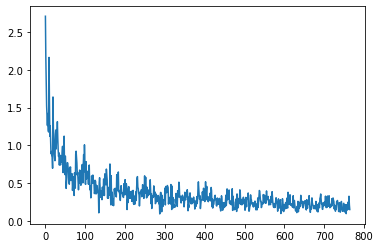

In [30]:
plt.figure()
plt.plot(all_losses)
plt.show()

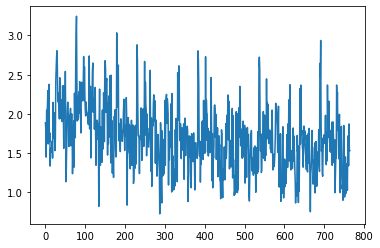

In [31]:
plt.figure()
plt.plot(all_grad_norms)
plt.show()

Now that we have trained our RNN, it's time to evaluate it on the test set.

In [0]:
# Evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support


def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)


# Make prediction for one sentence.
def rnn_predict_one_sent(model, sent_tensor):
    hidden = model.initHidden().to(device)

    predicted_tag_id = None
    # Your code here!
    length = sent_tensor.size()[0]
    outputs = torch.zeros(length, model.output_size).to(device)
    for t, sent_word in enumerate(sent_tensor):
        out, hidden = model(sent_word, hidden)
        outputs[t, :] = out
    predicted_tag_id = torch.argmax(outputs, dim=1)

    return predicted_tag_id

In [33]:
rnn_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = rnn_predict_one_sent(rnn_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7596449910001851, 0.7644447564369704, 0.7556438975349862)

## **Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Compute the gradient norm of all trainable parameters along the training. Plot a figure similar to what we did for training loss (x-axis is training iterations and y-axis is avg. gradient norm value). Describe what you find. Hint: gradient norm is the L2 norm of of the gradient vector.

2. Try to do learning with gradient clipping. Why should we use gradient clipping? What is the effect of gradient clipping? Could we use larger learning rate after gradient clipping? Why? Hint: use torch.nn.utils.clip_grad_norm(model.parameters(), clip) after loss.backward(). You can try various clipping range. A good starting point is clip = 5.

In [0]:
def train_rnn_model(num_vocabs, num_tags, rnn_hidden_size=128, epochs=5, learning_rate=1e-3, gnorm_clip=None, print_every=1000, plot_every=50):
    model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)

    criterion = nn.CrossEntropyLoss()
    rnn_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iter_count = 0

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = [] if plot_every is not None else None

    # Keep track of gradient norms for plotting
    current_grad_norm = 0
    all_grad_norms = [] if plot_every is not None else None

    start = time.time()

    model.train()
    for epoch_i in range(epochs):
        for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
            sent_tensor = sent_tensor.to(device)
            tag_tensor = tag_tensor.to(device)
      
            output, loss = rnn_train_one_sample(model, sent_tensor, tag_tensor, rnn_optimizer, clip=gnorm_clip)
            current_loss += loss
            current_grad_norm += compute_gradient_norm(model)

            if print_every is not None and iter_count % print_every == 0:
                print('%d %s %.4f' % (iter_count, timeSince(start), loss))

            # Add current loss avg to list of losses
            if plot_every is not None and iter_count % plot_every == 0 and iter_count > 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
                all_grad_norms.append(current_grad_norm / plot_every)
                current_grad_norm = 0

            iter_count += 1

    return model, all_losses, all_grad_norms

def evaluate_rnn_model(model):
    model.eval()
    predicted_tags = []
    for sent_tensor in test_data_oh_list:
        sent_tensor = sent_tensor.to(device)
        predicted_tag_id = rnn_predict_one_sent(model, sent_tensor)
        predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

    # Will output precision, recall, and f1 score.
    return evaluate_result(test_tags, predicted_tags)

In [0]:
rnn_model_def, all_losses_def, all_gnorms_def = train_rnn_model(num_vocabs, num_tags, print_every=None)
rnn_model_c1, all_losses_c1, all_gnorms_c1 = train_rnn_model(num_vocabs, num_tags, gnorm_clip=1, print_every=None)
rnn_model_c2, all_losses_c2, all_gnorms_c2 = train_rnn_model(num_vocabs, num_tags, gnorm_clip=2, print_every=None)
rnn_model_c3, all_losses_c3, all_gnorms_c3 = train_rnn_model(num_vocabs, num_tags, gnorm_clip=3, print_every=None)

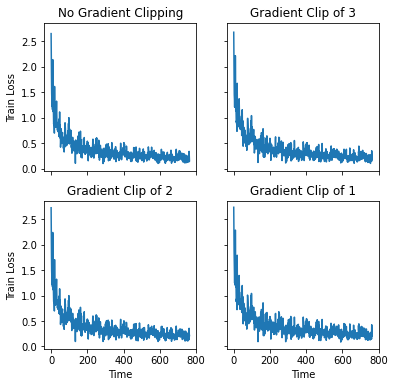

In [36]:
nrow = 2
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,6), sharex = True, sharey=True)

axs[0, 0].plot(all_losses_def)
axs[0, 0].set_title("No Gradient Clipping")
axs[0, 1].plot(all_losses_c3)
axs[0, 1].set_title("Gradient Clip of 3")
axs[1, 0].plot(all_losses_c2)
axs[1, 0].set_title("Gradient Clip of 2")
axs[1, 1].plot(all_losses_c1)
axs[1, 1].set_title("Gradient Clip of 1")

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Train Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Train Loss over Time with Different Levels of Gradient Clipping')
# plt.subplots_adjust(hspace=0.2)

plt.show()

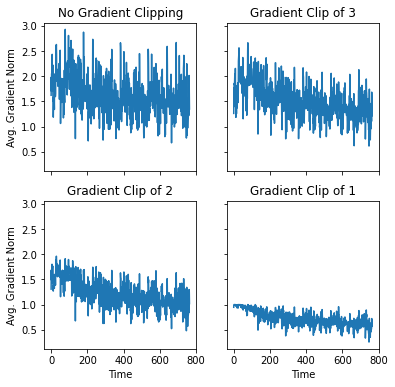

In [37]:
nrow = 2
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,6), sharex = True, sharey=True)

axs[0, 0].plot(all_gnorms_def)
axs[0, 0].set_title("No Gradient Clipping")
axs[0, 1].plot(all_gnorms_c3)
axs[0, 1].set_title("Gradient Clip of 3")
axs[1, 0].plot(all_gnorms_c2)
axs[1, 0].set_title("Gradient Clip of 2")
axs[1, 1].plot(all_gnorms_c1)
axs[1, 1].set_title("Gradient Clip of 1")

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Avg. Gradient Norm')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Gradient Norm over Time with Different Levels of Gradient Clipping')
# plt.subplots_adjust(hspace=0.2)

plt.show()

In [38]:
print(evaluate_rnn_model(rnn_model_def))
print(evaluate_rnn_model(rnn_model_c3))
print(evaluate_rnn_model(rnn_model_c2))
print(evaluate_rnn_model(rnn_model_c1))

(0.7720149840435705, 0.773807169025705, 0.7661463323721512)
(0.7550737839795382, 0.7583832653050371, 0.7505532166737924)
(0.7665939150986525, 0.7692721598125368, 0.7617993861596654)
(0.772310645818797, 0.7742363893608903, 0.7676394032600596)


In [0]:
# rnn_model_c2lr2, all_losses_c2lr2, all_gnorms_c2lr2 = train_rnn_model(num_vocabs, num_tags, learning_rate=1e-2, gnorm_clip=2)
# plt.figure()
# plt.plot(all_losses_c2lr2)
# plt.show()
# plt.figure()
# plt.plot(all_gnorms_c2lr2)
# plt.show()
# evaluate_rnn_model(rnn_model_c2lr2)

In [0]:
# rnn_model_c2lr53, all_losses_c2lr53, all_gnorms_c2lr53 = train_rnn_model(num_vocabs, num_tags, learning_rate=5e-3, gnorm_clip=2)
# plt.figure()
# plt.plot(all_losses_c2lr53)
# plt.show()
# plt.figure()
# plt.plot(all_gnorms_c2lr53)
# plt.show()
# evaluate_rnn_model(rnn_model_c2lr53)

In [0]:
from collections import defaultdict

rnn_losses_lr = defaultdict(dict)
rnn_gnorms_lr = defaultdict(dict)
rnn_results_lr = defaultdict(dict)

for clip in [1, 2]:
    for lr in [2e-3, 5e-3, 1e-2]:
        rnn_model_lrexp, all_losses_lrexp, all_gnorms_lrexp = train_rnn_model(num_vocabs, num_tags, learning_rate=lr, gnorm_clip=clip, print_every=None)
        rnn_losses_lr[clip][lr] = all_losses_lrexp
        rnn_gnorms_lr[clip][lr] = all_gnorms_lrexp
        rnn_results_lr[clip][lr] = evaluate_rnn_model(rnn_model_lrexp)

In [24]:
dict(rnn_results_lr)

{1: {0.002: (0.7662580791117483, 0.767176940325192, 0.7602121134019784),
  0.005: (0.7339384204852304, 0.7374918664296806, 0.7288614206912533),
  0.01: (0.7174253738373255, 0.7189349300836817, 0.7107231271165796)},
 2: {0.002: (0.7613165670135621, 0.7645392169242324, 0.7563896360774391),
  0.005: (0.7394561343421886, 0.7438605374275805, 0.7349665733784047),
  0.01: (0.6982278045564012, 0.7043494017979477, 0.6940453820424775)}}

# **Part 2: Long Short-Term Memory (LSTM)**

In part 2, you will implement your own LSTM. Same in part 1, you are not allowed to use PyTorch built-in LSTM/LSTMCell modules. For reference, you can look up the wikipage for the [LSTM architecture](https://en.wikipedia.org/wiki/Long_short-term_memory).

In [0]:
class LSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        # Your code here!
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W_xi = nn.Linear(self.input_size, self.hidden_size)
        self.W_hi = nn.Linear(self.hidden_size, self.hidden_size)
        self.input_sigmoid = nn.Sigmoid()

        self.W_xf = nn.Linear(self.input_size, self.hidden_size)
        self.W_hf = nn.Linear(self.hidden_size, self.hidden_size)
        self.forget_sigmoid = nn.Sigmoid()

        self.W_xo = nn.Linear(self.input_size, self.hidden_size)
        self.W_ho = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_sigmoid = nn.Sigmoid()

        self.W_xc = nn.Linear(self.input_size, self.hidden_size)
        self.W_hc = nn.Linear(self.hidden_size, self.hidden_size)
        self.cell_input_tanh = nn.Tanh()

        self.cell2hidden_tanh = nn.Tanh()

        self.hidden2output = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden, memory):
        # `input` is a 2d-tensor of shape (1, input_size);
        # `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size),
        # representing the hidden and memory states of the previous time step.

        # Your code here!
        input_gate = self.input_sigmoid(self.W_xi(input) + self.W_hi(hidden))
        forget_gate = self.forget_sigmoid(self.W_xf(input) + self.W_hf(hidden))
        output_gate = self.output_sigmoid(self.W_xo(input) + self.W_ho(hidden))

        cell_input = self.cell_input_tanh(self.W_xc(input) + self.W_hc(hidden))
        memory = forget_gate * memory + input_gate * cell_input
        hidden = output_gate * self.cell2hidden_tanh(memory)

        output = self.hidden2output(hidden)
        if not self.training:
            output = self.softmax(output)

        return output, hidden, memory

    def initHidden(self):
        # Initialize hidden and memory states.
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

Same with part 1, we provide the main training loop for training LSTM, but you will need to implement the `lstm_train_one_sample` function, and also apply gradient clipping.

In [0]:
learning_rate = 1e-3
lstm_hidden_size = 128

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)


def lstm_train_one_sample(model, sent_tensor, tag_tensor, optimizer, clip=None):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    length = sent_tensor.size()[0]
    outputs = torch.zeros(length, model.output_size).to(device)
    for t, sent_word in enumerate(sent_tensor):
        out, hidden, memory = model(sent_word, hidden, memory)
        outputs[t, :] = out

    loss = criterion(outputs, tag_tensor)

    optimizer.zero_grad()
    loss.backward()

    # Your Code here!
    if clip is not None:
        nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    optimizer.step()

    return outputs, loss.item()

LSTM main training loop:

In [0]:
n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of gradient norms for plotting
current_grad_norm = 0
all_grad_norms = []

start = time.time()

lstm_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor, lstm_optimizer)
        current_loss += loss
        current_grad_norm += compute_gradient_norm(lstm_model)

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            all_grad_norms.append(current_grad_norm / plot_every)
            current_grad_norm = 0

        iter_count += 1

0 0m 0s 2.8781
1000 0m 30s 2.6937
2000 0m 56s 0.7169
3000 1m 26s 2.1486
4000 1m 57s 1.4432
5000 2m 27s 0.1171
6000 2m 55s 0.5532
7000 3m 22s 0.4980
8000 3m 50s 0.3793
9000 4m 20s 0.9144
10000 4m 47s 0.2420
11000 5m 18s 0.4070
12000 5m 49s 0.0263
13000 6m 17s 0.0499
14000 6m 45s 0.0160
15000 7m 11s 1.1424
16000 7m 40s 0.2989
17000 8m 10s 0.0132
18000 8m 38s 0.0675
19000 9m 10s 0.0220
20000 9m 40s 0.9232
21000 10m 8s 0.0500
22000 10m 36s 0.1813
23000 11m 1s 0.2211
24000 11m 32s 0.0071
25000 11m 59s 0.0185
26000 12m 30s 0.3428
27000 13m 0s 0.0193
28000 13m 29s 0.0077
29000 13m 57s 1.6601
30000 14m 24s 0.0407
31000 14m 51s 0.0041
32000 15m 22s 0.0012
33000 15m 48s 0.0652
34000 16m 19s 0.0173
35000 16m 50s 0.5256
36000 17m 18s 0.0341
37000 17m 46s 0.1246
38000 18m 13s 0.1205


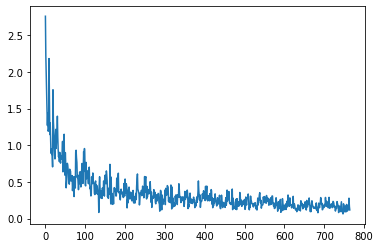

In [0]:
plt.figure()
plt.plot(all_losses)
plt.show()

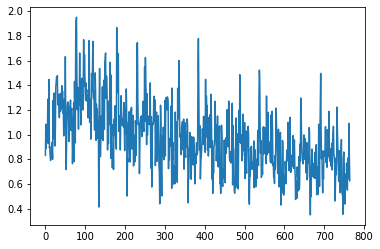

In [0]:
plt.figure()
plt.plot(all_grad_norms)
plt.show()

Now let's evaluate our LSTM model.

In [0]:
def lstm_predict_one_sent(model, sent_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    length = sent_tensor.size()[0]
    outputs = torch.zeros(length, model.output_size).to(device)
    for t, sent_word in enumerate(sent_tensor):
        out, hidden, memory = model(sent_word, hidden, memory)
        outputs[t, :] = out
    predicted_tag_id = torch.argmax(outputs, dim=1)

    return predicted_tag_id


lstm_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = lstm_predict_one_sent(lstm_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7662109206113973, 0.7684353299403762, 0.7612614012364994)

## **Part 2: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Change lstm_hidden_size so that LSTM has approximately the same amount of parameters as RNN. Hint: use sum(p.numel() for p in model.parameters() if p.requires_grad) to find the number of trainable parameters. Re-train the LSTM model and discuss your findings.

2. Same in part 1 writeup, plot the gradient norm figure for LSTM. Discuss your findings.

3. Currently we update model parameters for each sample (1 sample = 1 iteration). In practice, we usually train with a mini-batch (mB): the entire dataset of N samples is split into N/mB batches, and use one mini-batch for each update. Briefly describe how to do batching in our dataset. Hint: each sentence can have variable length.

In [0]:
def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print("Number of parameters in RNN model:", param_count(rnn_model))

learning_rate = 1e-3
lstm_hidden_size = 32

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)

print("Number of parameters in RNN model:", param_count(lstm_model))

Number of parameters in RNN model: 505873
Number of parameters in RNN model: 491953


In [0]:
def train_lstm_model(num_vocabs, num_tags, lstm_hidden_size=32, epochs=5, learning_rate=1e-3, gnorm_clip=None, print_every=1000, plot_every=50):
    lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                      output_size=num_tags).to(device)

    criterion = nn.CrossEntropyLoss()
    lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)

    iter_count = 0

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = [] if plot_every is not None else None

    # Keep track of gradient norms for plotting
    current_grad_norm = 0
    all_grad_norms = [] if plot_every is not None else None

    start = time.time()

    lstm_model.train()
    for epoch_i in range(epochs):
        for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
            sent_tensor = sent_tensor.to(device)
            tag_tensor = tag_tensor.to(device)
      
            output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor, lstm_optimizer, clip=gnorm_clip)
            current_loss += loss
            current_grad_norm += compute_gradient_norm(lstm_model)

            if print_every is not None and iter_count % print_every == 0:
                print('%d %s %.4f' % (iter_count, timeSince(start), loss))

            # Add current loss avg to list of losses
            if plot_every is not None and iter_count % plot_every == 0 and iter_count > 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
                all_grad_norms.append(current_grad_norm / plot_every)
                current_grad_norm = 0

            iter_count += 1
    return lstm_model, all_losses, all_grad_norms

In [0]:
def evaluate_lstm_model(model):
    model.eval()
    predicted_tags = []
    for sent_tensor in test_data_oh_list:
        sent_tensor = sent_tensor.to(device)
        predicted_tag_id = lstm_predict_one_sent(model, sent_tensor)
        predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

    # Will output precision, recall, and f1 score.
    return evaluate_result(test_tags, predicted_tags)

In [0]:
lstm_model_def, all_losses_lstm_def, all_gnorms_lstm_def = train_lstm_model(num_vocabs, num_tags, lstm_hidden_size=32)

0 0m 0s 2.8237
1000 0m 30s 3.1107
2000 0m 59s 0.9073
3000 1m 30s 2.0640
4000 2m 2s 1.3447
5000 2m 31s 0.1794
6000 2m 59s 0.6392
7000 3m 27s 1.0386
8000 3m 55s 0.3927
9000 4m 26s 0.9772
10000 4m 53s 0.2642
11000 5m 25s 0.4614
12000 5m 57s 0.0460
13000 6m 26s 0.0718
14000 6m 55s 0.0171
15000 7m 23s 1.0780
16000 7m 51s 0.1231
17000 8m 21s 0.0186
18000 8m 50s 0.0759
19000 9m 23s 0.0147
20000 9m 53s 1.2457
21000 10m 22s 0.1019
22000 10m 51s 0.3987
23000 11m 17s 0.1704
24000 11m 49s 0.0087
25000 12m 17s 0.0120
26000 12m 47s 0.4029
27000 13m 19s 0.0209
28000 13m 48s 0.0184
29000 14m 17s 1.9065
30000 14m 45s 0.0378
31000 15m 13s 0.0254
32000 15m 44s 0.0074
33000 16m 12s 0.0871
34000 16m 45s 0.0527
35000 17m 16s 0.3703
36000 17m 46s 0.0460
37000 18m 15s 0.1423
38000 18m 43s 0.4088


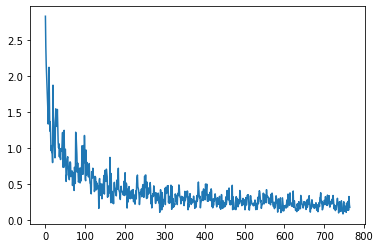

In [0]:
plt.figure()
plt.plot(all_losses_lstm_def)
plt.show()

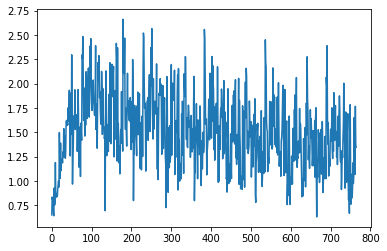

In [0]:
plt.figure()
plt.plot(all_gnorms_lstm_def)
plt.show()

In [0]:
evaluate_lstm_model(lstm_model_def)

(0.773407096141241, 0.7758152689477887, 0.7687349168384939)

In [0]:
lstm_model_c1, all_losses_lstm_c1, all_gnorms_lstm_c1 = train_lstm_model(num_vocabs, num_tags, gnorm_clip=1, print_every=None)

In [0]:
lstm_model_c2, all_losses_lstm_c2, all_gnorms_lstm_c2 = train_lstm_model(num_vocabs, num_tags, gnorm_clip=2, print_every=None)

In [0]:
lstm_model_c3, all_losses_lstm_c3, all_gnorms_lstm_c3 = train_lstm_model(num_vocabs, num_tags, gnorm_clip=3, print_every=None)

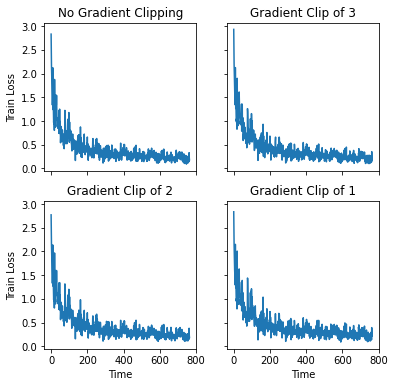

In [0]:
nrow = 2
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,6), sharex = True, sharey=True)

axs[0, 0].plot(all_losses_lstm_def)
axs[0, 0].set_title("No Gradient Clipping")
axs[0, 1].plot(all_losses_lstm_c3)
axs[0, 1].set_title("Gradient Clip of 3")
axs[1, 0].plot(all_losses_lstm_c2)
axs[1, 0].set_title("Gradient Clip of 2")
axs[1, 1].plot(all_losses_lstm_c1)
axs[1, 1].set_title("Gradient Clip of 1")

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Train Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('LSTM Train Loss over Time with Different Levels of Gradient Clipping')
# plt.subplots_adjust(hspace=0.2)

plt.show()

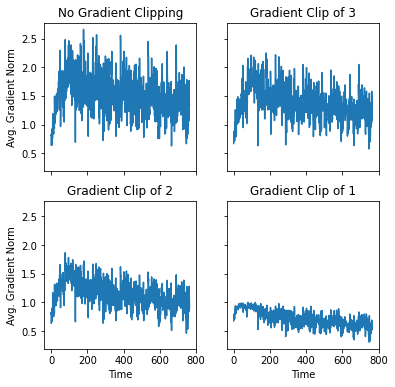

In [0]:
nrow = 2
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,6), sharex = True, sharey=True)

axs[0, 0].plot(all_gnorms_lstm_def)
axs[0, 0].set_title("No Gradient Clipping")
axs[0, 1].plot(all_gnorms_lstm_c3)
axs[0, 1].set_title("Gradient Clip of 3")
axs[1, 0].plot(all_gnorms_lstm_c2)
axs[1, 0].set_title("Gradient Clip of 2")
axs[1, 1].plot(all_gnorms_lstm_c1)
axs[1, 1].set_title("Gradient Clip of 1")

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Avg. Gradient Norm')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('LSTM Gradient Norm over Time with Different Levels of Gradient Clipping')
# plt.subplots_adjust(hspace=0.2)

plt.show()

In [0]:
print(evaluate_lstm_model(lstm_model_c3))
print(evaluate_lstm_model(lstm_model_c2))
print(evaluate_lstm_model(lstm_model_c1))

(0.7700997094171032, 0.7754801664625107, 0.7667259760296777)
(0.768780933386449, 0.7738908058909021, 0.7657927112846529)
(0.7728313881523314, 0.7769541543501074, 0.7690489097808335)
